# Reinforcement Learning Project: Control in a Continuous Action Space with DDPG

In this project, we will explore the Deep Deterministic Policy Gradient (DDPG) algorithm, which is designed to handle continuous action spaces in Reinforcement Learning. We will use the Pendulum-v1 environment implemented in OpenAI Gym to implement the DDPG algorithm from scratch to solve the classical control problem of stabilizing an inverted pendulum. Throughout the development, we will incrementally build the components of DDPG and analyze their importance for correct and effective learning. This Jupyter notebook contains our implementation and report for this project. 

The instructions are available in `Miniproject_DDPG.pdf` file.

Questions
* demander ce qu'on doit faire exactement pour le heatmap, c'est quoi les 3 axes?
* Part 5, deterministic or not? `loss_policy = policy_learning_update(agent, optimizer_policy, transitions, deterministic=False)`
* Are the heatmap plots for part 5 correct?
* Part 6, actor loss, should we use the target network or the local network?
* Part 7, what is evolve_state?

In [1]:
import numpy as np
from scipy import stats
import gym
from helpers import NormalizedEnv
from helpers import RandomAgent

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

from collections import deque


Global instances

In [2]:
# Select device: 'cpu' or 'cuda'
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)

# Create environement instance, an instance of the Pendulum-v1 environment wrapped in a NormalizedEnv class
# to normalize the action space between -1 and 1
env = gym.make('Pendulum-v1', render_mode='rgb_array')
env = NormalizedEnv(env)

Using device: cpu


## 3 Heuristic policy

In [79]:
# Create a RandomAgent
random_agent = RandomAgent(env)

def run_agent(agent: 'Agent', env: NormalizedEnv, num_episodes: int) -> float:
    """Run the agent for `num_episodes` episodes and return the average reward"""
    rewards = [] # Will contain the reward of each step
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        while True:
            # Simulation step
            action = agent.compute_action(state)
            state, reward, _, trunc, _ = env.step(action)
            episode_reward += reward
            if trunc:
                break
        rewards.append(episode_reward)
    return np.mean(rewards)

average_reward = run_agent(random_agent, env, 10)
print('Average reward over 10 episodes: {}'.format(average_reward))

Average reward over 10 episodes: -1043.15621199739


In [80]:
class HeuristicPendulumAgent:
    def __init__(self, env: NormalizedEnv, torque_intensity: float=1.0) -> None:
        """Heuristic agent for the Pendulum-v1 environment."""
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.torque_intensity = torque_intensity
        
    def compute_action(self, state) -> float:
        """Compute the action to apply to the environment.

        When the pendulum is in the lower half of the domain, applies a fixed torque in the same direction as the pendulum's angular velocity.
        When the pendulum is in the upper half of the domain, applies a fixed torque in the opposite direction as the pendulum's angular velocity.

        Warning: it returns a float, not a numpy array.
        """
        action = np.where(state[..., 0] < 0, # If the pendulum is in the lower half of the circle
                        np.sign(state[..., 2]) * self.torque_intensity, 
                        -np.sign(state[..., 2]) * self.torque_intensity)
        return action


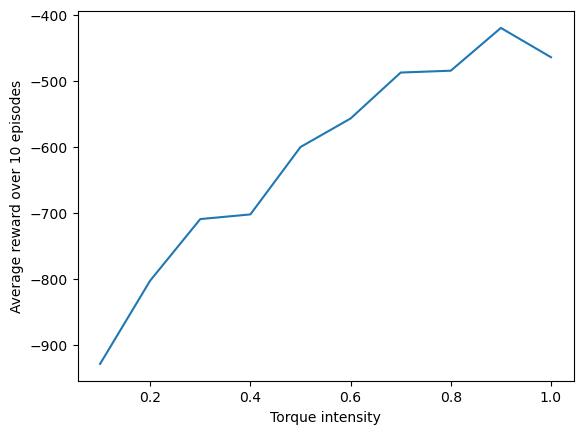

Best torque intensity: 0.9
Best reward over 10 episodes: -420.14569668681634


In [81]:
# Find best torque intensity
torque_intensities = np.linspace(0.1, 1, 10)
rewards = []
for torque_intensity in torque_intensities:
    heuristic_agent = HeuristicPendulumAgent(env, torque_intensity=torque_intensity)
    rewards.append(run_agent(heuristic_agent, env, 10))

plt.plot(torque_intensities, rewards)
plt.xlabel('Torque intensity')
plt.ylabel('Average reward over 10 episodes')
plt.show()

# Create a HeuristicPendulumAgent with the best torque intensity
heuristic_agent = HeuristicPendulumAgent(env, torque_intensity=torque_intensities[np.argmax(rewards)])
# Print best reward over 10 episodes and associated torque intensity
print('Best torque intensity: {}'.format(torque_intensities[np.argmax(rewards)]))
print('Best reward over 10 episodes: {}'.format(np.max(rewards)))


In [82]:
# Animation of the Heuristic Agent using PIL
state, _ = env.reset()
frames = []
while True:
    action = heuristic_agent.compute_action(state)
    state, reward, _, trunc, _ = env.step(action)
    frames.append(env.render())
    if trunc:
        break

frames = np.array(frames)
frames = [Image.fromarray(frame) for frame in frames]
frames[0].save("heuristic_agent.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)


## 4 Q function of the heuristic policy

In [83]:
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        """Buffer to store transitions.

        A transition is a tuple (state, action, reward, next_state, trunc) where:
            state (np.ndarray[(3,), np.float32]): State of the environment.
            action (np.ndarray[(1,), np.float32]): Action applied to the environment.
            reward (np.ndarray[(1,), np.float32]): Reward obtained after applying the action.
            next_state (np.ndarray[(3,), np.float32]): State of the environment after applying the action.
            trunc (np.ndarray[(1,), np.bool]): Boolean indicating if the episode is truncated.
        
        The buffer is implemented as 5 (one for each element of a transition) cyclic numpy arrays of shape 
        (capacity, *) where * is the shape of the corresponding element of a transition.
        When the buffer is full, the oldest transitions are dropped.
        
        Args:
            capacity (int): Capacity of the buffer.
            transition_type (np.dtype): Type of the transitions to store.
        """
        # Maximum number of transitions to store in the buffer. 
        # When the buffer overflows the old memories are dropped.
        self.capacity = capacity 
        # Numpy array of transitions
        self.states = np.empty((capacity, 3), np.float32)
        self.actions = np.empty((capacity, 1), np.float32)
        self.rewards = np.empty((capacity, 1), np.float32)
        self.next_states = np.empty((capacity, 3), np.float32)
        self.truncs = np.empty((capacity, 1), bool)
        # Index of the next transition to be stored
        self.index = 0
        # Current size of the buffer
        self.size = 0

    def append(self, transition):
        """Add a transition to the buffer.
        
        See constructor docstring for explanation of a transition.
        """
        # Add transition to current index
        self.states[self.index] = transition[0]
        self.actions[self.index] = transition[1]
        self.rewards[self.index] = transition[2]
        self.next_states[self.index] = transition[3]
        self.truncs[self.index] = transition[4]
        # Update index
        self.index = (self.index + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int):
        """Sample a batch of size `batch_size` of transitions from the buffers."""
        indexes = np.random.choice(self.size, batch_size, replace=False)
        return self[indexes]

    def __len__(self) -> int:
        return self.size
    
    def __getitem__(self, slice):
        return (self.states[slice], 
                self.actions[slice], 
                self.rewards[slice], 
                self.next_states[slice], 
                self.truncs[slice])


In [84]:
class QNetwork(nn.Module):
    def __init__(self, state_size: int=3, action_size: int=1):
        """QNetwork. Maps (state, action) pairs to Q-values."""
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, state, action):
        """Forward pass of the network.

        Args:
            state (torch.Tensor): State tensor
            action (torch.Tensor): Action tensor

        Returns:
            q_value (torch.Tensor): Q-value tensor
        """
        x = torch.cat([state, action], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


def TD_learning_update(q_network, agent, optimizer, transitions, gamma):
    """Perform a 1-step TD-learning update for a batch of transitions.

    Args:
        q_network (QNetwork): QNetwork instance
        agent (Agent): Agent (i.e. Policy) instance
        optimizer (torch.optim): Optimizer instance
        transitions (List[Transition]): Batch of transitions
        gamma (float): Discount factor

    Returns:
        loss (float): Loss value
    """
    states = transitions[0]
    actions = transitions[1]
    rewards = transitions[2]
    next_states = transitions[3]
    truncs = transitions[4]

    # Convert the numpy arrays to torch tensors
    states_t = torch.from_numpy(states).to(device)
    actions_t = torch.from_numpy(actions).to(device)
    rewards_t = torch.from_numpy(rewards).to(device)
    next_states_t = torch.from_numpy(next_states).to(device)
    truncs_t = torch.from_numpy(truncs).to(device)


    with torch.no_grad():
        next_actions = agent.compute_action(next_states)
        if not torch.is_tensor(next_actions):
            next_actions_t = torch.as_tensor(next_actions)[:, None].to(device, dtype=torch.float32)
        else: next_actions_t = next_actions
        # Naive next Q-values (i.e. without taking truncation into account)
        naive_next_qs = q_network(next_states_t, next_actions_t)
        # Actual next Q-values (i.e. taking truncation into account)
        next_qs = torch.where(truncs_t, 
                              torch.zeros_like(rewards_t), 
                              naive_next_qs)
        gamma = torch.tensor(gamma, dtype=torch.float32)
        targets = rewards_t + gamma * next_qs

    loss = F.mse_loss(q_network(states_t, actions_t), targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


In [85]:
capacity = 10000 # Capacity of the replay buffer
replay_buffer = ReplayBuffer(capacity=capacity)
q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0]).to(device)
q_network_before_training = copy.deepcopy(q_network)
optimizer = torch.optim.SGD(q_network.parameters(), lr=1e-4)
gamma = 0.99

# Training loop for the Q-learning
n_episodes = 1000 # Number of episodes
# Number of steps per episode, see documentation of the Pendulum-v1 environment
n_steps = 200
batch_size = 128 # Batch size for the TD-learning update
# Container for the loss of each step of each episode
losses = np.empty((n_episodes, n_steps))
logging_interval = 10
for episode in range(n_episodes):
    state, _ = env.reset()
    step = 0
    while True:
        # Simulation step
        action = heuristic_agent.compute_action(state)
        next_state, reward, _, trunc, _ = env.step(action)
        replay_buffer.append((state, action, reward, next_state, trunc))
        # Training step
        if len(replay_buffer) >= batch_size:
            transitions = replay_buffer.sample(batch_size)
            loss = TD_learning_update(q_network, heuristic_agent, optimizer, transitions, gamma)
            losses[episode, step] = loss.item()
        else:
            losses[episode, step] = np.nan

        if trunc:
            break
        state = next_state
        step += 1
    # Logging average loss of the last episode every `logging_interval` episodes
    if episode % logging_interval == 0 and episode > 0:
        print(f'Episode {episode}/{n_episodes-1}, average loss: {np.mean(losses[episode])}')


Episode 10/999, average loss: 111.58750220775605
Episode 20/999, average loss: 73.26018470525742
Episode 30/999, average loss: 84.5165561580658
Episode 40/999, average loss: 74.38174664020538
Episode 50/999, average loss: 77.84375289916993
Episode 60/999, average loss: 71.84791736602783
Episode 70/999, average loss: 76.83640377283096
Episode 80/999, average loss: 79.64355281829835
Episode 90/999, average loss: 73.52864589691163
Episode 100/999, average loss: 72.00888142585754
Episode 110/999, average loss: 77.19338422775269
Episode 120/999, average loss: 81.53923542737961
Episode 130/999, average loss: 68.84514513969421
Episode 140/999, average loss: 89.97666496753692
Episode 150/999, average loss: 76.5208717918396
Episode 160/999, average loss: 66.6424275636673
Episode 170/999, average loss: 72.54754450082778
Episode 180/999, average loss: 81.28015733718873
Episode 190/999, average loss: 79.08344672203064
Episode 200/999, average loss: 76.02131155490875
Episode 210/999, average loss: 

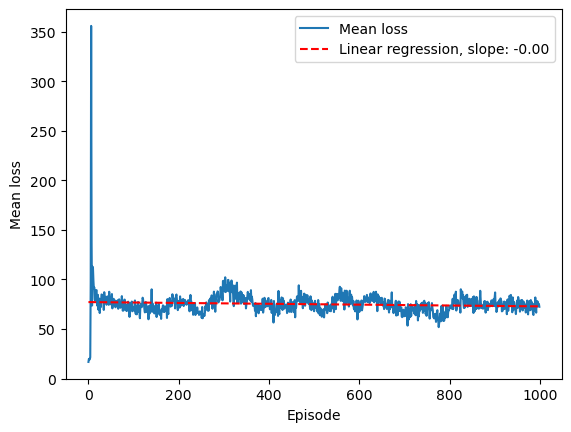

In [86]:
# Plot the mean loss per episode
plt.plot(np.nanmean(losses, axis=1))
# Add linear regression line
x = np.arange(n_episodes)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, np.nanmean(losses, axis=1))
plt.plot(x, slope*x + intercept, 'r--')

# legend
plt.legend(['Mean loss', 'Linear regression, slope: {:.2f}'.format(slope)])

plt.xlabel('Episode')
plt.ylabel('Mean loss')
plt.show()

(100, 100)


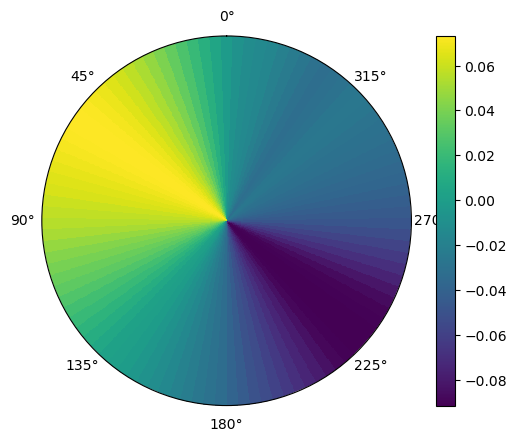

(100, 100)


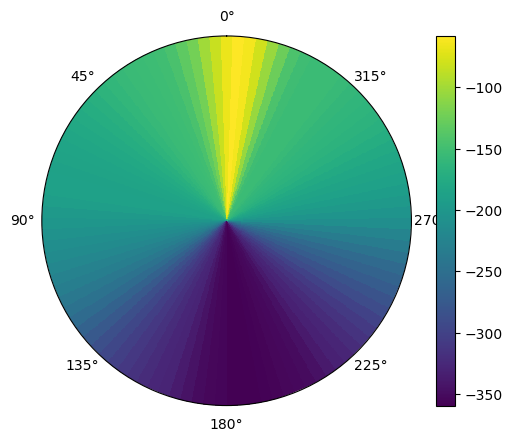

In [87]:
action = -1
velocity = 1

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)
states = np.empty([100, 100, 3])
states[...,0] = np.cos(th)
states[...,1] = np.sin(th)
states[...,2] = np.full((100,100), velocity)

actions = np.full((100,100, 1), action)


#before training
z = q_network_before_training(torch.Tensor(states), torch.Tensor(actions)).detach().squeeze()

print(np.array(z).shape)


fig = plt.figure()

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)

ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')

ax.set_yticklabels([])

p = plt.pcolormesh(th, r, z)
fig.colorbar(p)

plt.plot(azm, r, color='k', ls='none') 
plt.grid()

plt.show()

#after training
z = q_network(torch.Tensor(states), torch.Tensor(actions)).detach().squeeze()

print(np.array(z).shape)


fig = plt.figure()

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)

ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')

ax.set_yticklabels([])

p = plt.pcolormesh(th, r, z)
fig.colorbar(p)

plt.plot(azm, r, color='k', ls='none') 
plt.grid()

plt.show()

## 5 Minimal implementation of DDPG

In [88]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_size: int=3, action_size: int=1):
        """PolicyNetwork. Maps states to actions."""
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, state):
        """Forward pass of the network.

        Args:
            state (torch.Tensor): State tensor

        Returns:
            action (torch.Tensor): Action tensor
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

In [89]:
class GaussianActionNoise:
    def __init__(self, sigma: float=0.3):
        assert(sigma>0), 'sigma must be positive'
        self.sigma = sigma

    def get_noisy_action(self, action: torch.Tensor):
        noise = torch.normal(mean=0, std=self.sigma, size=action.shape)
        return torch.clamp(action + noise, -1, +1)
    
class OUActionNoise:
    def __init__(self, theta: float=0.15, sigma: float=0.3):
        assert(theta>=0 and theta<=1), 'theta must be between 0 and 1 (included)'
        assert(sigma>=0), 'sigma must non-negative'
        self.theta = theta
        self.sigma = sigma
        self.noise = torch.zeros(env.action_space.shape[0])
        
    def get_noisy_action(self, action: torch.Tensor):
        self.noise = (1-self.theta)*self.noise + torch.normal(0, self.sigma, size=self.noise.shape)
        return torch.clamp(action + self.noise, -1, +1)


In [90]:
class DDPGAgent:
    def __init__(self, action_noise: 'ActionNoise'=GaussianActionNoise()):
        self.policy_network = PolicyNetwork().to(device)
        self.noise = action_noise
        
    def compute_action(self, state, deterministic=True):
        state_t = torch.from_numpy(state).to(device)
        action = self.policy_network(state_t)
        if not deterministic:
            action = self.noise.get_noisy_action(action)
        return action
    
def policy_learning_update(agent, optimizer, transitions, deterministic: bool=True):
    states = transitions[0]

    # Convert the numpy arrays to torch tensors
    states_t = torch.from_numpy(states).to(device)
    
    
    actions_t = agent.compute_action(states, deterministic)

    # Next Q-values (without taking truncation ??)
    qs = q_network(states_t, actions_t)

    loss = -qs.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [103]:
capacity = 10000 # Capacity of the replay buffer
replay_buffer = ReplayBuffer(capacity=capacity)
q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0]).to(device)
q_network_before_training = copy.deepcopy(q_network)
agent = DDPGAgent(sigma=0.3)
optimizer_q = torch.optim.SGD(q_network.parameters(), lr=1e-4)
optimizer_policy = torch.optim.SGD(agent.policy_network.parameters(), lr=1e-4)
gamma = 0.99

# Training loop for the Q-learning
n_episodes = 600 # Number of episodes
# Number of steps per episode, see documentation of the Pendulum-v1 environment
n_steps = 200
batch_size = 128 # Batch size for the TD-learning update
# Container for the loss of each step of each episode
losses_q = np.empty((n_episodes, n_steps))
losses_policy = np.empty((n_episodes, n_steps))
episode_rewards = np.empty(n_episodes)
logging_interval = 10
for episode in range(n_episodes):
    state, _ = env.reset()
    step = 0
    episode_reward = 0
    while True:
        # Simulation step
        action = agent.compute_action(state, deterministic=False).detach().numpy()
        next_state, reward, _, trunc, _ = env.step(action)
        episode_reward += reward
        replay_buffer.append((state, action, reward, next_state, trunc))
        # Training step
        if len(replay_buffer) >= batch_size:
            transitions = replay_buffer.sample(batch_size)
            loss_q = TD_learning_update(q_network, agent, optimizer_q, transitions, gamma)
            losses_q[episode, step] = loss_q.item()
            # TODO ask deterministic or not
            loss_policy = policy_learning_update(agent, optimizer_policy, transitions, deterministic=False)
            losses_policy[episode, step] = loss_policy.item()
        else:
            losses_q[episode, step] = np.nan
            losses_policy[episode, step] = np.nan

        if trunc:
            break
        state = next_state
        step += 1
    episode_rewards[episode] = episode_reward
    # Logging average loss of the last episode every `logging_interval` episodes
    if episode % logging_interval == 0 and episode > 0:
        print(f'Episode {episode}/{n_episodes-1}, average loss q-network: {np.mean(losses_q[episode])}, average loss policy network: {np.mean(losses_policy[episode])}')


def train_ddpg(agent, q_network, optimizer_q, optimizer_policy, n_episodes: int=1000, batch_size: int=128, gamma: float=0.99, logging_interval: int=10, capacity: int=10000):
    """Train the DDPG agent.

    Args:
        agent (DDPGAgent): The agent to train.
        q_network (QNetwork): The Q-network to train.
        optimizer_q (torch.optim.Optimizer): The optimizer for the Q-network.
        optimizer_policy (torch.optim.Optimizer): The optimizer for the policy network.
        n_episodes (int, optional): Number of episodes to train. Defaults to 1000.
        batch_size (int, optional): Batch size for the TD-learning update. Defaults to 128.
        gamma (float, optional): Discount factor. Defaults to 0.99.
        logging_interval (int, optional): Logging interval. Defaults to 10.
        capacity (int, optional): Capacity of the replay buffer. Defaults to 10000.
    
    Returns:
        (np.ndarray, np.ndarray, np.ndarray): The losses of the Q-network, the losses of the policy network and the episode rewards.
    """
    # Number of steps per episode, see documentation of the Pendulum-v1 environment
    n_steps = 200
    replay_buffer = ReplayBuffer(capacity=capacity)
    # Container for the loss of each step of each episode
    losses_q = np.empty((n_episodes, n_steps))
    losses_policy = np.empty((n_episodes, n_steps))
    episode_rewards = np.empty(n_episodes)
    for episode in range(n_episodes):
        state, _ = env.reset()
        step = 0
        episode_reward = 0
        while True:
            # Simulation step
            action = agent.compute_action(state, deterministic=False).detach().numpy()
            next_state, reward, _, trunc, _ = env.step(action)
            episode_reward += reward
            replay_buffer.append((state, action, reward, next_state, trunc))
            # Training step
            if len(replay_buffer) >= batch_size:
                transitions = replay_buffer.sample(batch_size)
                loss_q = TD_learning_update(q_network, agent, optimizer_q, transitions, gamma)
                losses_q[episode, step] = loss_q.item()
                # TODO ask deterministic or not
                loss_policy = policy_learning_update(agent, optimizer_policy, transitions, deterministic=False)
                losses_policy[episode, step] = loss_policy.item()
            else:
                losses_q[episode, step] = np.nan
                losses_policy[episode, step] = np.nan

            if trunc:
                break
            state = next_state
            step += 1
        episode_rewards[episode] = episode_reward
        # Logging average loss of the last episode every `logging_interval` episodes
        if episode % logging_interval == 0 and episode > 0:
            print(f'Episode {episode}/{n_episodes-1}, average loss q-network: {np.mean(losses_q[episode])}, average loss policy network: {np.mean(losses_policy[episode])}')

    return losses_q, losses_policy, episode_rewards

Episode 10/599, average loss q-network: 1090.2693516540528, average loss policy network: 499.62587509155276
Episode 20/599, average loss q-network: 907.5115096092225, average loss policy network: 430.9827799987793
Episode 30/599, average loss q-network: 701.7686213874817, average loss policy network: 372.1736831665039
Episode 40/599, average loss q-network: 702.987597770691, average loss policy network: 356.10211166381833
Episode 50/599, average loss q-network: 675.0490183734894, average loss policy network: 351.8479853820801
Episode 60/599, average loss q-network: 527.1908956575394, average loss policy network: 316.09475051879883
Episode 70/599, average loss q-network: 456.04892326831816, average loss policy network: 300.52089317321776
Episode 80/599, average loss q-network: 490.6405821323395, average loss policy network: 304.0636430358887
Episode 90/599, average loss q-network: 480.53268570423126, average loss policy network: 295.67970886230466
Episode 100/599, average loss q-network

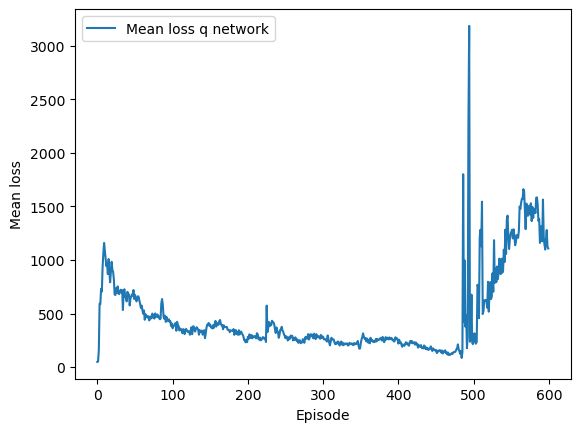

In [104]:
# Plot the mean loss of q network per episode
plt.plot(np.nanmean(losses_q, axis=1))

# legend
plt.legend(['Mean loss q network', 'Linear regression, slope: {:.2f}'.format(slope)])

plt.xlabel('Episode')
plt.ylabel('Mean loss')
plt.show()

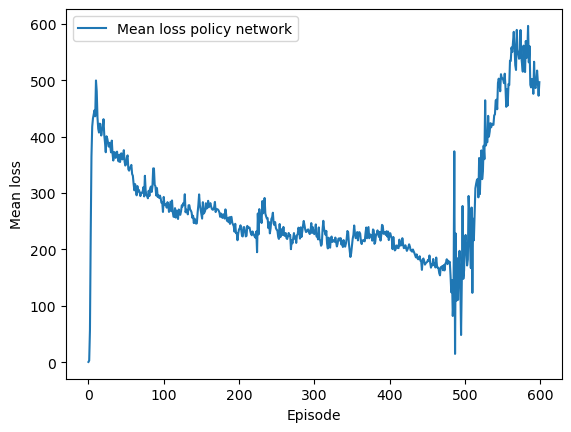

In [105]:
# Plot the mean loss of policy network per episode
plt.plot(np.nanmean(losses_policy, axis=1))

# legend
plt.legend(['Mean loss policy network', 'Linear regression, slope: {:.2f}'.format(slope)])

plt.xlabel('Episode')
plt.ylabel('Mean loss')
plt.show()

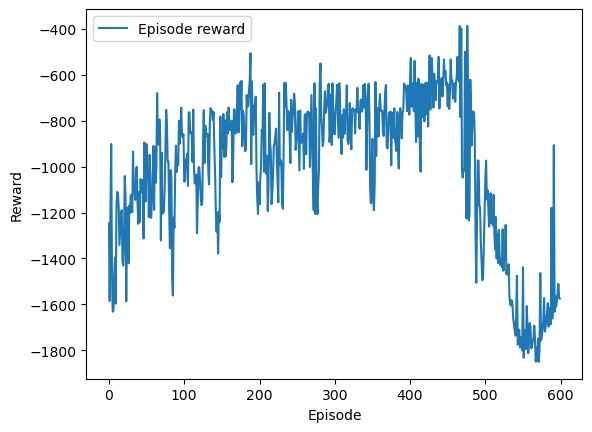

In [106]:
# Plot the episode reward for each episode
plt.plot(episode_rewards)

# legend
plt.legend(['Episode reward', 'Linear regression, slope: {:.2f}'.format(slope)])

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [107]:
n_episodes = 100
episode_rewards = np.empty(n_episodes)
for episode in range(n_episodes):
    episode_reward = 0
    state, _ = env.reset()
    while True:
        action = agent.compute_action(state, deterministic=False).detach().numpy()
        next_state, reward, _, trunc, _ = env.step(action)
        episode_reward += reward
        if trunc:
            break
        state = next_state

    episode_rewards[episode] = episode_reward

print('Average reward over 100 episodes: {}'.format(np.mean(episode_rewards)))
print(episode_rewards)

Average reward over 100 episodes: -1533.3759561004401
[-1545.60788935 -1577.59759468 -1568.39162033 -1444.26226414
 -1502.38998075 -1524.96151923 -1594.47245147 -1554.50738501
 -1555.13290903 -1593.56666127 -1600.32870206 -1591.61891462
 -1548.61683305 -1360.35689731 -1500.18470196 -1240.98914428
 -1363.72236705 -1492.66113286 -1543.79100439 -1590.46742938
 -1604.96320688 -1552.38653475 -1495.9076284  -1443.00070492
 -1559.92601576 -1593.88002822 -1592.46089359 -1561.70670191
 -1578.22953174 -1596.39369467 -1480.63662308 -1343.14626602
 -1511.84296252 -1582.96267586 -1580.81709119 -1509.63178546
 -1537.56807697 -1603.20598752 -1598.21650387 -1582.84529587
 -1345.64330492 -1563.61387878 -1571.46126725 -1545.12462064
 -1596.31197689 -1544.18275986 -1573.18200045 -1574.89936857
 -1602.87837456 -1594.24307309 -1561.11521919 -1561.71738516
 -1582.49608182 -1465.33124321 -1577.13040549 -1576.77920422
 -1565.10207246 -1397.41745465 -1537.92463144 -1383.92198497
 -1513.8992043  -1551.45528101 

(100, 100)


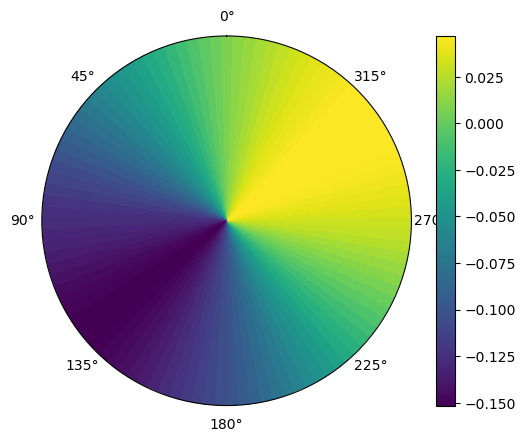

(100, 100)


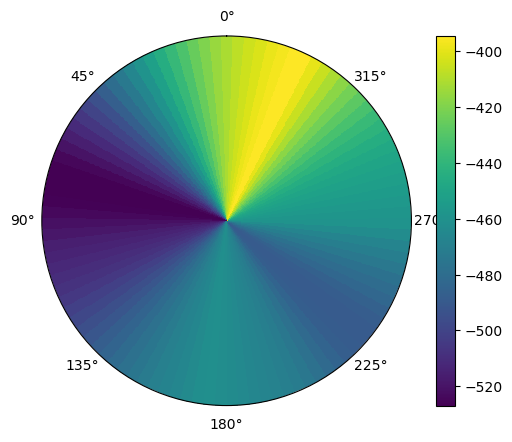

In [108]:
action = -1
velocity = 1

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)
states = np.empty([100, 100, 3])
states[...,0] = np.cos(th)
states[...,1] = np.sin(th)
states[...,2] = np.full((100,100), velocity)

actions = np.full((100,100, 1), action)


#before training
z = q_network_before_training(torch.Tensor(states), torch.Tensor(actions)).detach().squeeze()

print(np.array(z).shape)


fig = plt.figure()

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)

ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')

ax.set_yticklabels([])

p = plt.pcolormesh(th, r, z)
fig.colorbar(p)

plt.plot(azm, r, color='k', ls='none') 
plt.grid()

plt.show()

#after training
z = q_network(torch.Tensor(states), torch.Tensor(actions)).detach().squeeze()

print(np.array(z).shape)


fig = plt.figure()

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)

ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')

ax.set_yticklabels([])

p = plt.pcolormesh(th, r, z)
fig.colorbar(p)

plt.plot(azm, r, color='k', ls='none') 
plt.grid()

plt.show()

## 6. Target networks